# Анализ оттока клиентов банка "Метанпром"

# Part 0. Декомпозиция 

Мне в работу поступила задача по анализу клиентов регионального банка "Метанпром" и выделению сегментов клиентов, которые склонны уходить из банка.  
Мои задачи в данном проекте:
 - провести исследовательский анализ данных;
 - составить портрет клиента, который склонен уходить из банка;  
 - дать рекомендации по таким клиентам; 
 - проиллюстрировать исследование для заказчика в виде презентации.

Для понимания этапности действий создам план исследования (декомпозицию):

1. Изучение и обработка общей информации  

    - загрузка данных и оценка их количества и полноты
    - описание данных (количество и тип)
    - поиск и удаление явных дубликатов  
    - поиск неявных дубликаатов по ключвым столбцам "city", "gender", "est_salary"
    - работа с пропусками данных  
        - в столбеце "age" 26 пропусков, необходимо понять природу пропусков (MAR/MNAR) и после это принять решение о замене пропущенных значений (если будем восполнять данные, то будем делать это после оценки корреляционной зависимости).  
        - в столбце "balance" 2295 пропусков, необходимо понять природу пропусков (MAR/MNAR) и после это принять решение о замене пропущенных значений (если будем восполнять данные, то будем делать это после оценки корреляционной зависимости).  

    - изменение наименования колонок на строчные символы
    - изменение типов данных (данные в столбцах score, age, est_salary с float на int)  
    - замена значений в столбце "gender" с М/Ж на 1/0 соответственно
    - добавление трех столбцов (is_jaroslavl, is_ribinsk, is_rostov), характеризующих город открытия счета (заполнены будут 1/0) 

2. Исследование данных  
    - посмотрим круговую диаграмму распределения клиентов по полу, городу, лояльности к банку, наличию кредитной карты, активности      
    - посмотрим столбчатый график распределение клиентов по количеству используемых продуктов банка, количеству объектов в собственности   
    - посмотрим гистрограмму распределения клиентов по показателям уровня заработной платы, счету в банке, баллам кредитного скоринга, возрасту  
    

Осмотрим общую корреляцию Фейкера для всего датасета и опишем зависимости.

    - посмотрим распределение клиентов по зарплате наложением двух графиков по показателю оттока  
    - посмотрим распределение клиентов по размеру баланса наложением двух графиков по показателю оттока  
    - посмотрим распределение клиентов по распределению возраста наложением двух графиков по показателю оттока  
    - посмотрим распределение клиентов по скору наложением двух графиков по показателю оттока
    

3. Проверка статистических гипотез (1-гипотеза о различии среднего баланса между двумя типичными категориями клиентов, 2-гипотеза о различии доли отточных клиентов между двумя типичными категориями клиентов )

4. Промежуточные выводы по показателям, которые стратегически влияют на отток клиентов банка

5. Определение сегментов клиентов на основе стратегических показателей

6. Выводы и рекомендации заказчику

7. Подготовка и представление презентации заказчику (с указанием только реально влияющих характеристик клиентов на отток с предложениями по удержанию)

# Part I. Загрузка и предобработка данных 

**загрузка данных и библиотек**

In [1]:
!pip install phik

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from scipy import stats as st
import math as mth
from plotly import graph_objects as go
import plotly.subplots as sp
import phik
import scipy.stats as stats
import statsmodels.api as sm
import os

**загрузка и осмотр датасета**

In [4]:
pth1 = '/Users/evgeniagonina/Downloads/bank_scrooge.csv'
pth2 = 'https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
else:
    print('Something is wrong')
data.head(3) 

USERID  score     city gender   age  equity    balance  products  \
0  183012  850.0  Рыбинск      Ж  25.0       1   59214.82         2   
1  146556  861.0  Рыбинск      Ж  37.0       5  850594.33         3   
2  120722  892.0  Рыбинск      Ж  30.0       0        NaN         1   

   credit_card  last_activity  EST_SALARY  churn  
0            0              1    75719.14      1  
1            1              0    86621.77      0  
2            1              1   107683.34      0

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Представленные данные распределены по 12 столбцам и 10000 строкам:  
- `USERID` — идентификатор пользователя, тип данных "int64" - устраивает
- `score` — баллы кредитного скоринга, тип данных "float64" - изменим на "int64"
- `city` — город, тип данных "object" - устраивает
- `gender` — пол, тип данных "object" - устраивает
- `age` — возраст, тип данных "float64" - изменим на "int64", отсутствует часть данных
- `equity`  — количество баллов собственности, тип данных "int64" - устраивает
- `balance` — баланс на счёте, тип данных "float64" - изменим на "int64", , отсутствует часть данных
- `products` — количество продуктов, которыми пользуется клиент, тип данных "int64" - устраивает
- `credit_card` — есть ли кредитная карта, тип данных "int64" - устраивает
- `last_activity` — активный клиент, тип данных "int64" - устраивает
- `est_salary` — заработная плата клиента, тип данных "float64" - изменим на "int64
- `churn` — ушёл или нет, тип данных "int64" - устраивает

Датасет предоставлен с некоторым количеством пропущенных значений, а это значит, что теперь нам надо выяснить, как корректно обработать эти пропуски.
Двигаемся дальше.

**переименование столбцов**

Изменим наименование столбцов на строчное и изменим наименование столбца `USERID` по типу camelcase:

In [6]:
data.columns = data.columns.str.lower()
data = data.rename(columns={'userid':'user_id'})
data.head(5)

user_id  score       city gender   age  equity     balance  products  \
0   183012  850.0    Рыбинск      Ж  25.0       1    59214.82         2   
1   146556  861.0    Рыбинск      Ж  37.0       5   850594.33         3   
2   120722  892.0    Рыбинск      Ж  30.0       0         NaN         1   
3   225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
4   157978  730.0  Ярославль      М  34.0       5      174.00         1   

   credit_card  last_activity  est_salary  churn  
0            0              1    75719.14      1  
1            1              0    86621.77      0  
2            1              1   107683.34      0  
3            0              1   174423.53      1  
4            1              0    67353.16      1

**работа с дубликатами**

Проверим на содержание явных дублей:

In [7]:
print(f'число явных дублей:{data.duplicated().sum()}')

число явных дублей:0


Проверим как обстоят дела с дубликатами по user_id:

In [8]:
print(data[['user_id']].duplicated().sum())

73


Получили 73 дубликата по 'user_id'. В целом 'user_id' самый уникальный показатель и не может дублироваться, но у нас данные за три города и, возможно, база данных велась не общая по банку, а по каждому городу, тогда такое совпадение объяснимо.  
Проверим на уникальность в пересечении 'user_id' и 'city'

In [9]:
print(data[['user_id', 'city']].duplicated().sum())

0


Наша догадка получила подтверждение данными: пересечений по id и городу нет. Так что дубликатов среди id нет, это пользователи, открывшие счет в разных городах. Но все же можно дать совет: либо делать префикс у id в зависимости от города, либо вести объединенную базу данных.  
Есть еще один вариант произошедшего: возможно один клиент открывал счета в разных городах (т.е. и получается, что id его уникальный, а город открытия разный).  
В любом случае, на данном этапе принимаем решение о неудалении дубликатов по 'user_id'.

**добавление столбцов по полу**

In [10]:
data = pd.get_dummies(data, columns=['gender'], drop_first= False )

**обработка пропущенных значений столбца 'age'**

In [11]:
data['age'].isna().sum()

26

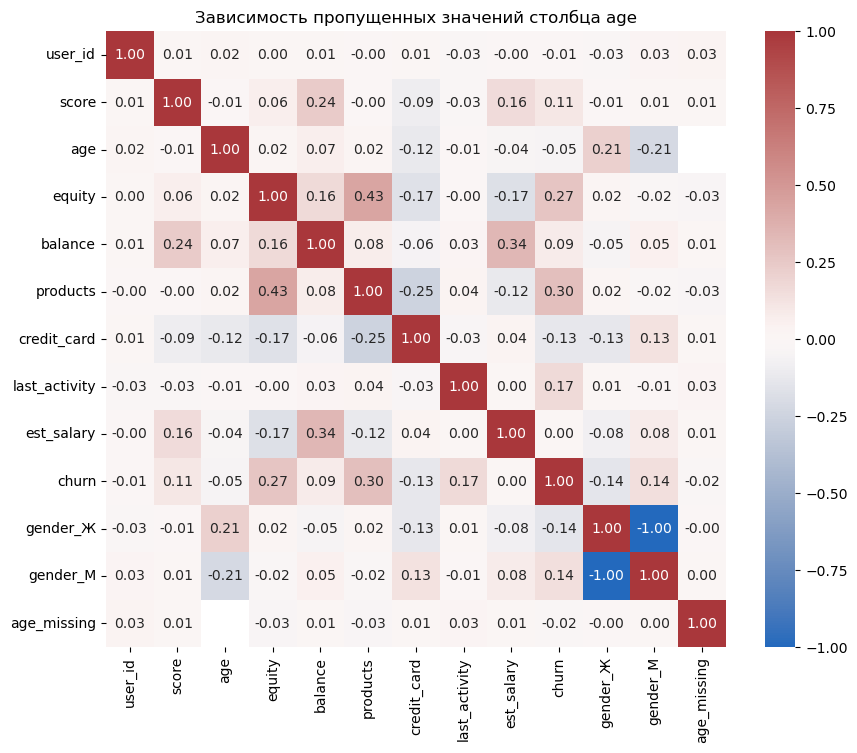

In [12]:
data['age_missing'] = data['age'].isna()
correlation_matrix_age = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_age, cmap='vlag', center=0, annot=True, fmt='.2f')
plt.title('Зависимость пропущенных значений столбца age')
plt.show()

Значимых зависимостей пропущенных значений 'age' не обнаружено, соответсвенно пропуски не зависят от переменных и мы можем заполнить данные по медианному значению. Группировка столбцов для получения более точного медианного значения тут не имеет смысла, так как зависимостей нет.

Дополнительно отмечу, что у возраста есть слабая зависимость к полу: для женщин прямая, для мужчин - обратная.

In [13]:
data = data.drop('age_missing', axis=1)
median_age = data['age'].median()
data['age'] = data['age'].fillna(median_age)
data['age'].isna().sum()

0

**обработка пропущенных значений столбца 'balance'**

In [14]:
data['balance'].isna().sum()

2295

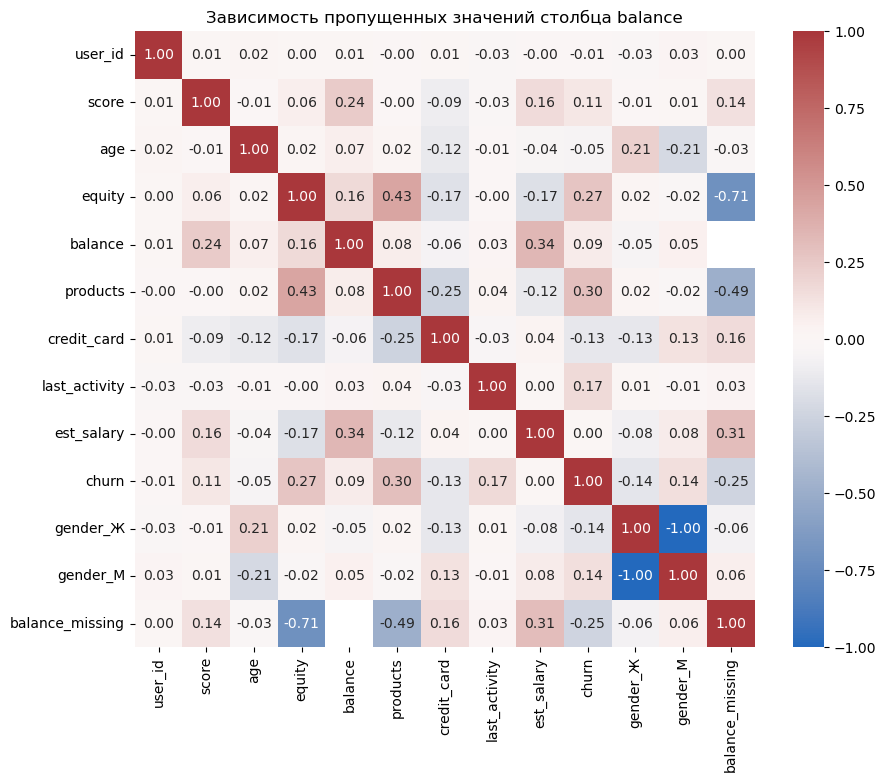

In [15]:
data['balance_missing'] = data['balance'].isna()
correlation_matrix_age = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_age, cmap='vlag', center=0, annot=True, fmt='.2f')
plt.title('Зависимость пропущенных значений столбца balance')
plt.show()

Для пропущенных значений столбца balace ситуация другая: тут есть высокая корреляция к показателю количества баллов собственности, и слабая корреляция к показателям количества продуктов и заработной плате. Особое внимание стоит уделить именно зависимости от количества баллов собственности- это означает, что с увеличением количества баллов собственности в датафрейме, вероятность отсутствия данных в столбце "balance" уменьшается.  Так же отметим, что слабая корреляция не обязательно означает, что есть причинно-следственная связь между этими переменными. Корреляция может указывать на существование статистической связи между переменными, но не обязательно на причинность.    
Соответственно заполним пропущенные значения по столбцам 'equity', 'products'

In [16]:
data['balance_missing'] = data['balance'].isna()
median_balance = data.groupby(['equity', 'products', 'churn', 'credit_card'])['balance'].transform('median')

data['salary_category'] = pd.qcut(data['est_salary'], q=4)  
data['balance'] = data['balance'].fillna(median_balance)
data = data.drop(['balance_missing', 'salary_category'], axis=1)
print(data['balance'].isna().sum())

1


In [17]:
overall_median = data['balance'].median()
data['balance'] = data['balance'].fillna(overall_median)
data['balance'].isna().sum()

0

**добавление столбцов по городам**

In [19]:
data = pd.get_dummies(data, columns=['city'], drop_first= False)

**изменение типов данных**

In [21]:
data[['score', 'age', 'est_salary', 'balance']] = data[['score', 'age', 'est_salary', 'balance']].astype(int)

**выявление аномалий в столбце products**

In [22]:
data['products'].value_counts()

2    5126
1    3341
3    1039
4     474
5      19
0       1
Name: products, dtype: int64

Видим, что у 1 клиента 0 продуктов банка. Это вызывает вопросы. Как может быть клиентом человек, который не использует продукты банка? Покажем этого клиента сотрудникам банка для того, чтобы они смогли уточнить данные по нему. А для нашего исследования удалим эту строку.

In [23]:
display(data.query('products == 0'))

user_id  score  age  equity  balance  products  credit_card  \
8957   147837    962   79       3   375946         0            0   

      last_activity  est_salary  churn  gender_Ж  gender_М  city_Ростов  \
8957              0       25063      1         1         0            0   

      city_Рыбинск  city_Ярославль  
8957             1               0

In [24]:
data = data.drop(data[data['products'] == 0].index)

**Вывод 1 раздела**

In [25]:
data.head(2)

user_id  score  age  equity  balance  products  credit_card  last_activity  \
0   183012    850   25       1    59214         2            0              1   
1   146556    861   37       5   850594         3            1              0   

   est_salary  churn  gender_Ж  gender_М  city_Ростов  city_Рыбинск  \
0       75719      1         1         0            0             1   
1       86621      0         1         0            0             1   

   city_Ярославль  
0               0  
1               0

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   user_id         9999 non-null   int64
 1   score           9999 non-null   int64
 2   age             9999 non-null   int64
 3   equity          9999 non-null   int64
 4   balance         9999 non-null   int64
 5   products        9999 non-null   int64
 6   credit_card     9999 non-null   int64
 7   last_activity   9999 non-null   int64
 8   est_salary      9999 non-null   int64
 9   churn           9999 non-null   int64
 10  gender_Ж        9999 non-null   uint8
 11  gender_М        9999 non-null   uint8
 12  city_Ростов     9999 non-null   uint8
 13  city_Рыбинск    9999 non-null   uint8
 14  city_Ярославль  9999 non-null   uint8
dtypes: int64(10), uint8(5)
memory usage: 908.1 KB


В результате предобработки данных сделано следующее:  
 - переименовали столбцы датасета,  
 - проверили на наличие явных дубликатов,  
 - проверили и нашли дубликаты столбца `user_id`, объяснили их происхождение и оставили их,  
 - выяснили, что пропуски в столбце `age` типа MCAR и восполнили их по общей медиане,  
 - выяснили, что пропуски в столбце `balance` условно типа MNAR (выявлена только 1 сильная зависимость) и восполнили их по медиане, полученной в результате группировки `equity`, `products`,  
 - добавили столбцы, определяющие принадлежность к полу и к городу,  
 - изменили тип данных в столбцах.

# Part II. Исследование данных

**общее исследование данных**

Посмотрим круговую диаграмму распределения клиентов по полу, городу, лояльности к банку, наличию кредитной карты, активности: 

In [27]:
data

user_id  score  age  equity  balance  products  credit_card  \
0      183012    850   25       1    59214         2            0   
1      146556    861   37       5   850594         3            1   
2      120722    892   30       0   118644         1            1   
3      225363    866   51       5  1524746         2            0   
4      157978    730   34       5      174         1            1   
...       ...    ...  ...     ...      ...       ...          ...   
9995   120553    814   27       1    78144         1            0   
9996   139170    894   46       0   118644         1            1   
9997   115639    903   24       0   105606         2            1   
9998   148700    777   68       3   865457         3            0   
9999    96267    828   58       3  1180886         4            0   

      last_activity  est_salary  churn  gender_Ж  gender_М  city_Ростов  \
0                 1       75719      1         1         0            0   
1                 0       86621      0         1         0            0   
2                 1      107683      0         1         0            0   
3                 1      174423      1         1         0            0   
4                 0       67353      1         0         1            0   
...             ...         ...    ...       ...       ...          ...   
9995              1       18943      0         0         1            0   
9996              0      196898      0         0         1            0   
9997              1      108905      0         0         1            0   
9998              1       86874      0         1         0            0   
9999              1       21422      0         1         0            0   

      city_Рыбинск  city_Ярославль  
0                1               0  
1                1               0  
2                1               0  
3                0               1  
4                0               1  
...            ...             ...  
9995             1               0  
9996             0               1  
9997             0               1  
9998             0               1  
9999             1               0  

[9999 rows x 15 columns]

In [28]:
gender_counts = data[['gender_Ж', 'gender_М']].sum()
city_counts = data[['city_Ростов', 'city_Рыбинск', 'city_Ярославль']].sum()
churn_counts = data['churn'].value_counts()
credit_card_counts = data['credit_card'].value_counts()
last_activity_counts = data['last_activity'].value_counts()

fig = sp.make_subplots(rows=2, cols=3, subplot_titles=[
    'полу',
    'городу',
    'отточности',
    'наличию кредитной карты',
    'активности'
], specs=[[{'type': 'pie'}, {'type': 'pie'}, None],
          [{'type': 'pie'}, {'type': 'pie'}, {'type': 'pie'}]])

fig.add_trace(go.Pie(values=gender_counts, labels=gender_counts.index), row=1, col=1)
fig.add_trace(go.Pie(values=city_counts, labels=city_counts.index), row=1, col=2)
fig.add_trace(go.Pie(values=churn_counts, labels=churn_counts.index), row=2, col=1)
fig.add_trace(go.Pie(values=credit_card_counts, labels=credit_card_counts.index), row=2, col=2)
fig.add_trace(go.Pie(values=last_activity_counts, labels=last_activity_counts.index), row=2, col=3)
fig.update_layout(title={'text': 'Распределение клиентов по:', 'x': 0.5, 'y': 0.95, 'xanchor': 'center',\
                         'yanchor': 'top'})
fig.show()


Теперь мы можем описать общее распределение данные по категориям:  
  - по полу:  
    - женщины 50%  
    - мужчины 50%  
  - по городам:  
    - Ярославль 58,9% (более половины всех клиентов)
    - Рыбинск 26,9%  
    - Ростов 14,2%  
  - по наличию кредитной карты:  
    - есть кредитная карта 68%
    - нет кредитной карты 32%  
  - по активности:  
    - активен 52,4%  
    - не активен 47,6%
  - по отточности:  
    - не отточны 81,8%
    - отточны 18,2%

Посмотрим столбчатый график распределение клиентов по количеству используемых продуктов банка, количеству объектов в собственности  

In [29]:
products_counts = data['products'].value_counts().sort_index()
equity_counts = data['equity'].value_counts().sort_index()

fig = sp.make_subplots(rows=1, cols=2, subplot_titles=[
    'Количеству продуктов',
    'Количеству объектов в собственности'])
fig.add_trace(go.Bar(x=products_counts.index, y=products_counts.values), row=1, col=1)
fig.update_xaxes(title_text='Количество продуктов', row=1, col=1)
fig.update_yaxes(title_text='Количество клиентов', row=1, col=1)

total_products = len(data['products'])
percent_products = [f'{(count / total_products) * 100:.2f}%' for count in products_counts.values]
fig.update_traces(text=percent_products, textposition='auto', row=1, col=1)

fig.add_trace(go.Bar(x=equity_counts.index, y=equity_counts.values), row=1, col=2)
fig.update_xaxes(title_text='Количество объектов в собственности', row=1, col=2)
fig.update_yaxes(title_text='Количество клиентов', row=1, col=2)

total_equity = len(data['equity'])
percent_equity = [f'{(count / total_equity) * 100:.2f}%' for count in equity_counts.values]
fig.update_traces(text=percent_equity, textposition='auto', row=1, col=2)

fig.update_layout(title={'text': 'Распределение клиентов по:', 'x': 0.5, 'y': 0.95, 'xanchor': 'center', 'yanchor': 'top'})
fig.show()

Продолжим описывать общее распределение данные по категориям:  
  - по количеству используемых продуктов банка:  
    - 2 продукта у 51,26% клиентов  
    - 1 продукт у 33,41% клиентов  
    - 3 продукта у 10,39% клиентов  
    - 4 продукта у 4,74% клиентов  
    - 5 продуктов у 0,19% клиентов  


  - по количеству объектов в собственности:  
    - 0 объектов у 25,92% клиентов  
    - 5 объектов у 19,18% клиентов  
    - 4 объекта у 18,5% клиентов  
    - 3 объекта у 15,43% клиентов  
    - 2 объекта у 10,52% клиентов  
    - 1 объект у 7,74% клиентов  
    - 6 объектов у 1,61% клиентов  
    - 7 объектов у 0,8% клиентов  
    - 8 объектаов у 0,17% клиентов  
    - 9 объектов у 0,13% клиентов  


Посмотрим гистрограмму распределения клиентов по показателям уровня заработной платы, счету в банке, баллам кредитного скоринга, возрасту

In [30]:
fig1 = go.Figure(data=[go.Histogram(x=data['est_salary'])])
fig1.update_layout(title='Распределение клиентов по заработной плате')
median_salary = np.median(data['est_salary'])
fig1.add_vline(x=median_salary, line_dash="dash", line_color="red",
               annotation_text=f"Median: {median_salary:.2f}", annotation_position="top")

fig2 = go.Figure(data=[go.Histogram(x=data['balance'])])
fig2.update_layout(title='Распределение клиентов по балансу')
median_balance = np.median(data['balance'])
fig2.add_vline(x=median_balance, line_dash="dash", line_color="red",
               annotation_text=f"Median: {median_balance:.2f}", annotation_position="top")

fig3 = go.Figure(data=[go.Histogram(x=data['score'])])
fig3.update_layout(title='Распределение клиентов по баллам кредитного скоринга')
median_score = np.median(data['score'])
fig3.add_vline(x=median_score, line_dash="dash", line_color="red",
               annotation_text=f"Median: {median_score:.2f}", annotation_position="top")

fig4 = go.Figure(data=[go.Histogram(x=data['age'])])
fig4.update_layout(title='Распределение клиентов по возрасту')
median_age = np.median(data['age'])
fig4.add_vline(x=median_age, line_dash="dash", line_color="red",
               annotation_text=f"Median: {median_age:.2f}", annotation_position="top")

fig1.show()
fig2.show()
fig3.show()
fig4.show()


По получившимся графикам опишем два распределения:  
  - по баллам кредитного скоринга:  
    - данные распределены в промежутке от 640 до 1000 баллов  
    - медианный показатель равен 853 баллам
    - форма распределения близкая к нормальному. 
  - по возрасту:  
    - возраст клиентов распределен в промежутке от 18 до 86 лет  
    - медианный показатель возраста равен 40 годам. 
    - форма распределения близкая к нормальному с ассиметричным хвостом в правой части  

Данные по показателям заработной платы и балансу клиента описывать проблематично в виду наличия выбросов. Сначала обработаем эти данные, а потом дополнительно опишем.

Обработка данных по заработной плате

In [31]:
fig = go.Figure()
fig.add_trace(go.Box(x=data['est_salary'], name='est_salary', orientation='h'))
fig.update_layout(xaxis_title='Заработная плата', title='Boxplot для показателя заработной платы')
fig.show()

Выбросы наинаются после 323 тыс рублей. Для построения гистограммы отбросим данные после 0,6 млн рублей:

In [32]:
threshold = 0.6e6
filtered_data = data[data['est_salary'] <= threshold]

fig = go.Figure(data=[go.Histogram(x=filtered_data['est_salary'])])
fig.update_layout(xaxis_title='Заработная плата', yaxis_title='Количество клиентов',
                  title='Распределение клиентов по заработной плате (с обрезанными показателями выбросов)')
median_salary = np.median(filtered_data['est_salary'])
fig.add_vline(x=median_salary, line_dash="dash", line_color="red",
              annotation_text=f"Median: {median_salary:.2f}", annotation_position="top")
fig.show()

Теперь опишем данные о заработной плате:  
    - уровень зарплаты распределен в промежутке от 5 тыс рублей до 1,4 млн рублей  
    - медианный показатель уровня зарплаты равен 117 тыс рублей   
    - форма распределения близкая к нормальному с ассиметричным хвостом в правой части

Аналогично поступим для данных о балансе:

In [33]:
fig = go.Figure()
fig.add_trace(go.Box(x=data['balance'], name='balance', orientation='h'))
fig.update_layout(xaxis_title='Баланс клиента', title='Boxplot для показателя баланса клиента')
fig.show()

Выбросы наинаются после 802 тыс рублей. Для построения гистограммы отбросим данные после 3 млн рублей:

In [34]:
threshold = 3.0e6
filtered_data_balance = data[data['balance'] <= threshold]

fig = go.Figure(data=[go.Histogram(x=filtered_data_balance['balance'])])
fig.update_layout(xaxis_title='Баланс клиента', yaxis_title='Количество клиентов',
                  title='Распределение клиентов по балансу (с обрезанными показателями выбросов)')

median_salary = np.median(filtered_data_balance['balance'])
fig.add_vline(x=median_salary, line_dash="dash", line_color="red",
              annotation_text=f"Median: {median_salary:.2f}", annotation_position="top")
fig.show()



Теперь опишем данные о балансе:  
    - баланс клиентов распределен в промежутке от 0 рублей до 119 млн рублей  
    - медианный показатель уровня баланса равен 368 тыс рублей   
    - форма распределения не нормальная, с пиком 100-150 тыс рублей и с ассиметричным хвостом в правой части

**Коэффициентом корреляции фик проверим связь (категориальных/непрерывных) характеристик с показателями оттока (churn)**

interval columns not set, guessing: ['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'churn', 'gender_Ж', 'gender_М', 'city_Ростов', 'city_Рыбинск', 'city_Ярославль']


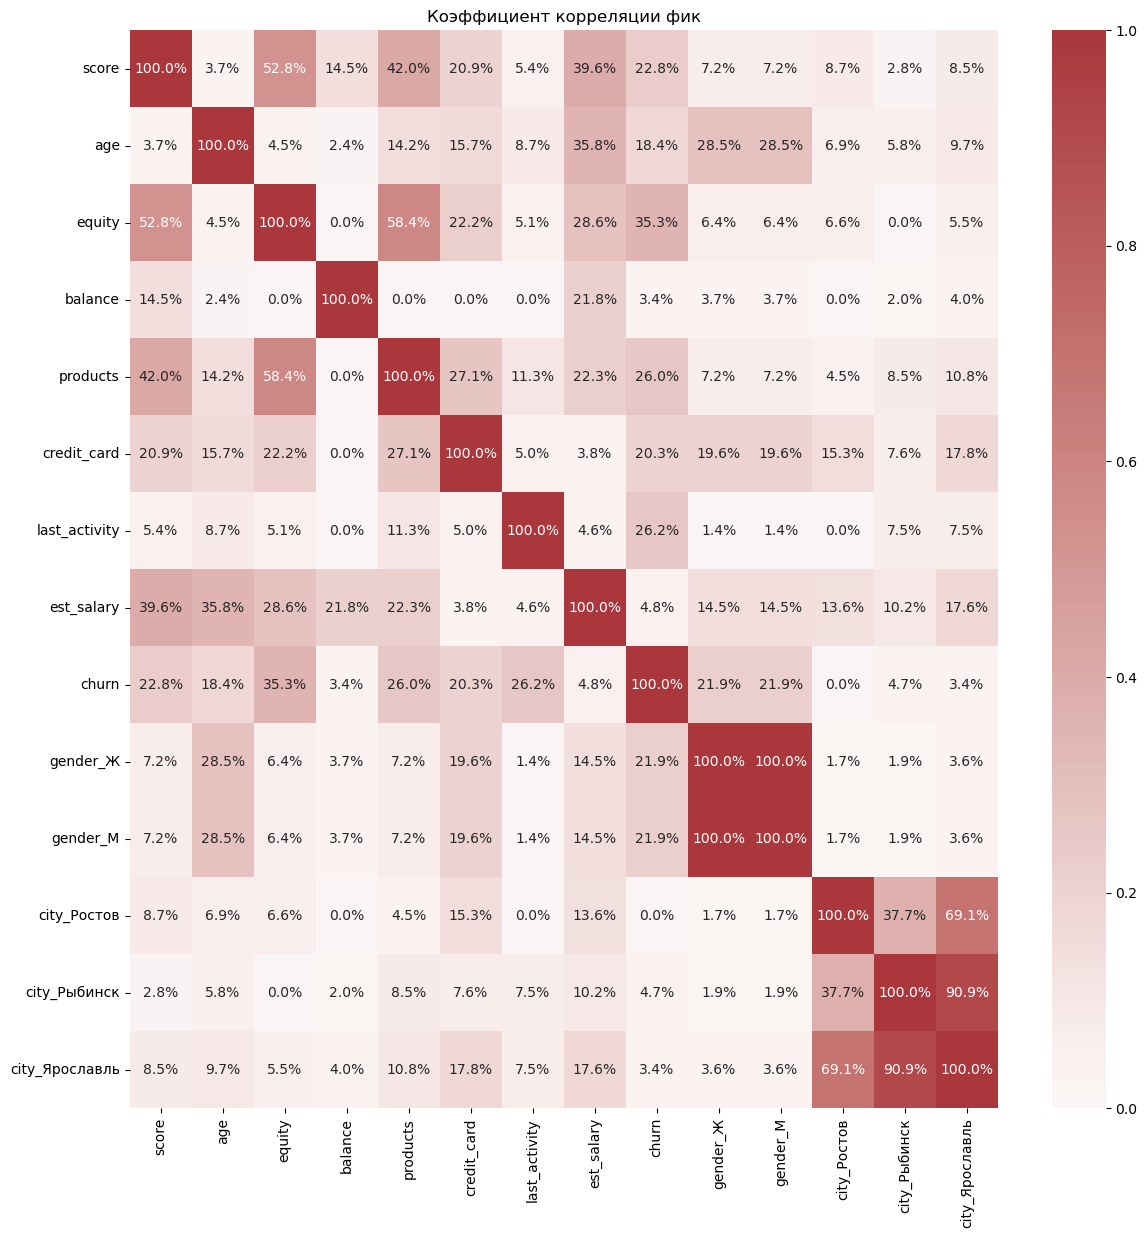

In [35]:
data_mat_corr = data[['score', 'age', 'equity', 'balance', 'products', 'credit_card',
                      'last_activity', 'est_salary', 'churn', 'gender_Ж', 'gender_М',
                      'city_Ростов', 'city_Рыбинск', 'city_Ярославль']]
data_mat_corr = data_mat_corr.phik_matrix()

plt.figure(figsize=(14, 14))
sns.heatmap(data_mat_corr, cmap='vlag', center=0, annot=True, fmt='.1%', cbar=True)
plt.title('Коэффициент корреляции фик')
plt.show()


К показателю оттока выявлены следующие корреляции:  
 - слабая корреляция (10%-30%):  
   - по полу  
   - по активности  
   - по наличию кредитной карты  
   - по возрасту  
   - по баллам кредитного скоринга  
 - умеренная корреляция(30%-50%):  
   - по количеству баллов собственности  
   - по количеству используемых продуктов

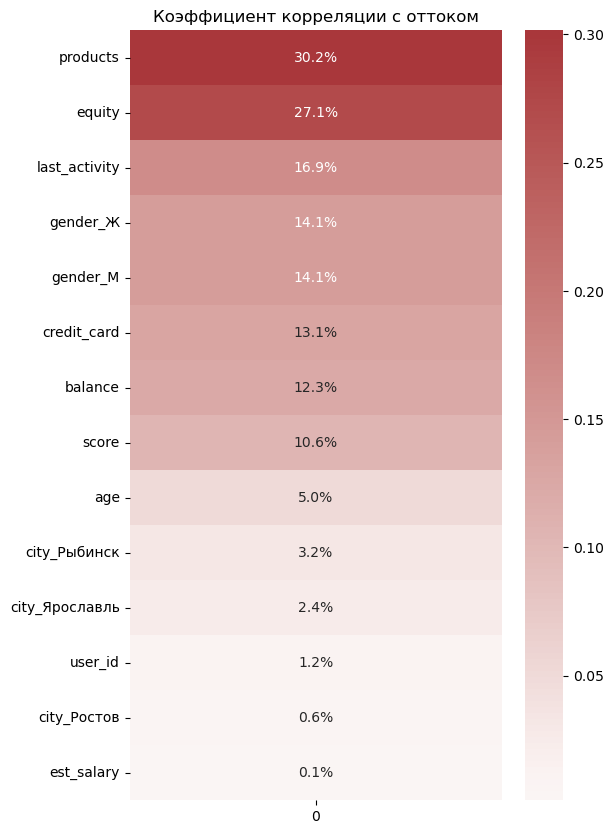

In [36]:
# корреяция для презентации
corr_with_churn = data.corrwith(data['churn'])
churn_corr = corr_with_churn.drop('churn')
churn_corr = churn_corr.abs().sort_values(ascending=False)
plt.figure(figsize=(6, 10))
sns.heatmap(churn_corr.to_frame(), cmap='vlag', center=0, annot=True, fmt='.1%', cbar=True)
plt.title('Коэффициент корреляции с оттоком')
plt.show()


**рассмотрение оттока по категориям**

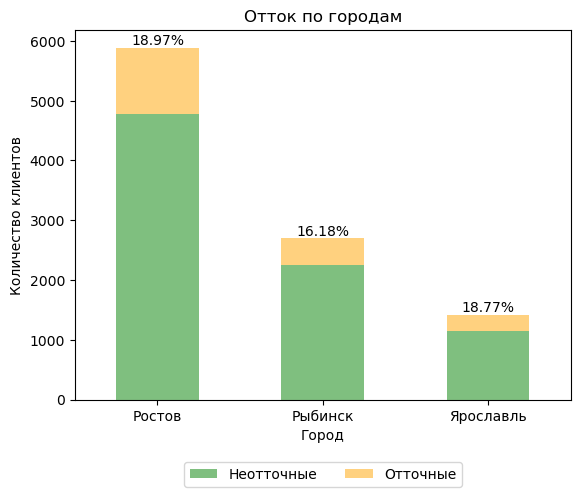

In [37]:
grouped_data_by_city = data.groupby(['city_Ростов', 'city_Рыбинск', 'city_Ярославль', 'churn']).size().unstack()
city_labels = ['Ростов', 'Рыбинск', 'Ярославль']
total_customers_by_city = grouped_data_by_city.sum(axis=1)
not_churned_percentage_by_city = grouped_data_by_city[1] / total_customers_by_city * 100
ax = grouped_data_by_city.plot(kind='bar', stacked=True, color=['green', 'orange'], alpha=0.5)
ax.set_xticklabels(city_labels, rotation=0)
for i, v in enumerate(not_churned_percentage_by_city):
    ax.text(i, grouped_data_by_city.iloc[i, 0] + grouped_data_by_city.iloc[i, 1], f'{v:.2f}%', ha='center', va='bottom')
 
plt.title('Отток по городам')
plt.xlabel('Город')
plt.ylabel('Количество клиентов')
plt.legend(['Неотточные', 'Отточные'], bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
plt.show()

По данному графику видим, что показатели оттока для Ярославля и Ростова примерно равны, а в Рыбинске на 2,5% меньше. Что делает Рыбинск более устойчивым к оттоку.

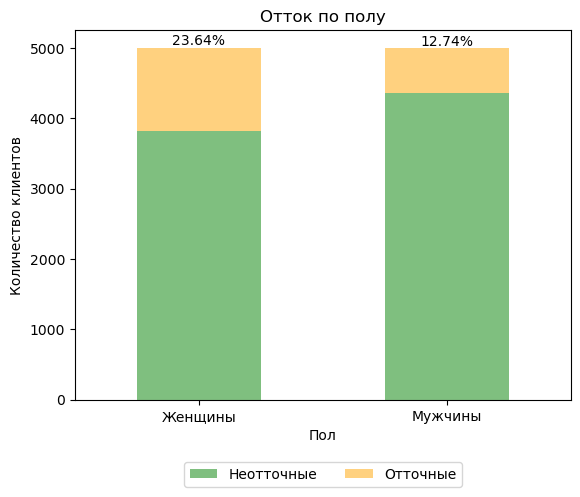

In [38]:
grouped_data = data.groupby(['gender_Ж', 'gender_М', 'churn']).size().unstack()
gender_labels = ['Женщины', 'Мужчины']
total_customers = grouped_data.sum(axis=1)
not_churned_percentage = grouped_data[1] / total_customers * 100
ax = grouped_data.plot(kind='bar', stacked=True, color=['green', 'orange'], alpha=0.5)
ax.set_xticklabels(gender_labels, rotation=0)
for i, v in enumerate(not_churned_percentage):
    ax.text(i, grouped_data[0][i] + grouped_data[1][i], f'{v:.2f}%', ha='center', va='bottom')

plt.title('Отток по полу')
plt.xlabel('Пол')
plt.ylabel('Количество клиентов')
plt.legend(['Неотточные', 'Отточные'], bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
plt.show()

Распределение клиентов между ужчинами и женщинами почти равное, а вот отток среди пользователей женского пола больше, чем среди мужского на 10,9%.

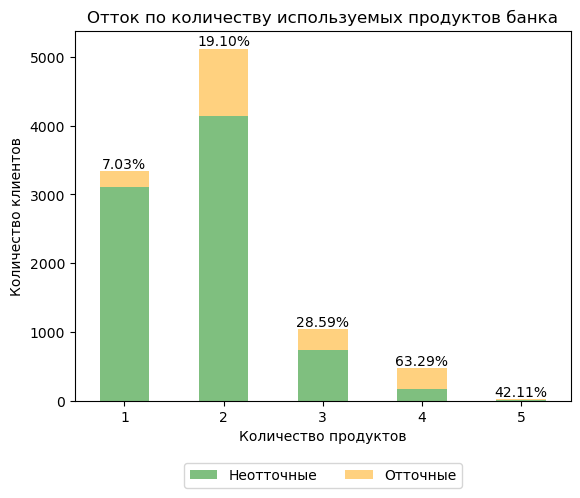

In [39]:
grouped_data_by_city = data.groupby(['products', 'churn']).size().unstack()
city_labels = ['1', '2', '3','4', '5']
total_customers_by_city = grouped_data_by_city.sum(axis=1)
not_churned_percentage_by_city = grouped_data_by_city[1] / total_customers_by_city * 100
ax = grouped_data_by_city.plot(kind='bar', stacked=True, color=['green', 'orange'], alpha=0.5)
ax.set_xticklabels(city_labels, rotation=0)
for i, v in enumerate(not_churned_percentage_by_city):
    ax.text(i, grouped_data_by_city.iloc[i, 0] + grouped_data_by_city.iloc[i, 1],\
            f'{v:.2f}%', ha='center', va='bottom')
 
plt.title('Отток по количеству используемых продуктов банка')
plt.xlabel('Количество продуктов')
plt.ylabel('Количество клиентов')
plt.legend(['Неотточные', 'Отточные'], bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
plt.show()

Тут проиллюстрирован отток клиентов по продуктам банка. Самые отточные те, у кого от 3 до 5 продуктов, самые устойчивые - с 1 продуктом. 

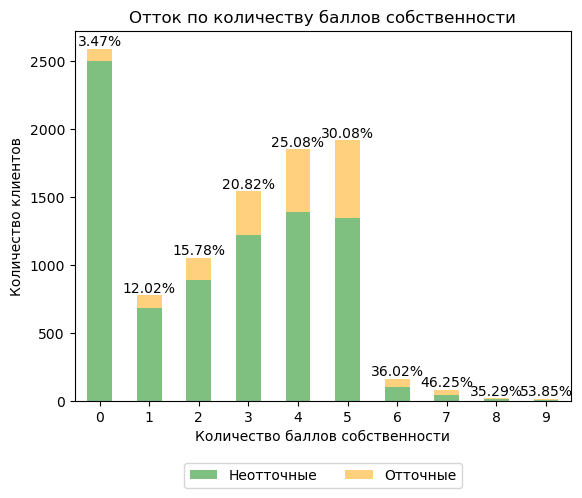

In [40]:
grouped_data_by_city = data.groupby(['equity', 'churn']).size().unstack()
city_labels = ['0', '1', '2', '3','4', '5', '6', '7', '8', '9']
total_customers_by_city = grouped_data_by_city.sum(axis=1)
not_churned_percentage_by_city = grouped_data_by_city[1] / total_customers_by_city * 100
ax = grouped_data_by_city.plot(kind='bar', stacked=True, color=['green', 'orange'], alpha=0.5)
ax.set_xticklabels(city_labels, rotation=0)
for i, v in enumerate(not_churned_percentage_by_city):
    ax.text(i, grouped_data_by_city.iloc[i, 0] + grouped_data_by_city.iloc[i, 1], f'{v:.2f}%',\
            ha='center', va='bottom')
 
plt.title('Отток по количеству баллов собственности')
plt.xlabel('Количество баллов собственности')
plt.ylabel('Количество клиентов')
plt.legend(['Неотточные', 'Отточные'], bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
plt.show()

На этом графике проиллюстрирован отток по кооличеству баллов собственности. Лучшие клиенты для банка те, у кого 1 балл, а вот у клиентов с количество баллов от 5 отток составляет более 30% 

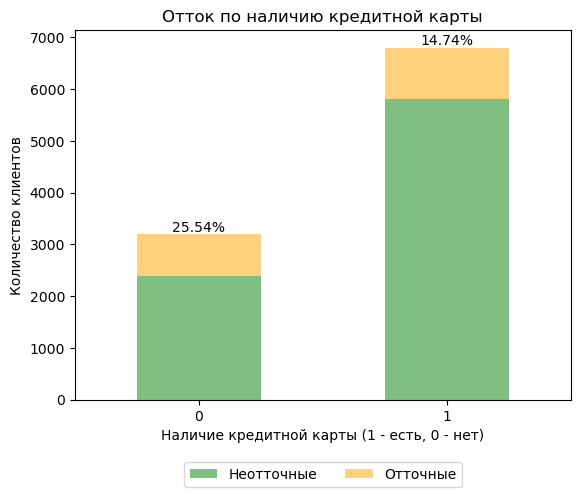

In [41]:
grouped_data_by_city = data.groupby(['credit_card', 'churn']).size().unstack()
city_labels = ['0', '1']
total_customers_by_city = grouped_data_by_city.sum(axis=1)
not_churned_percentage_by_city = grouped_data_by_city[1] / total_customers_by_city * 100
ax = grouped_data_by_city.plot(kind='bar', stacked=True, color=['green', 'orange'], alpha=0.5)
ax.set_xticklabels(city_labels, rotation=0)
for i, v in enumerate(not_churned_percentage_by_city):
    ax.text(i, grouped_data_by_city.iloc[i, 0] + grouped_data_by_city.iloc[i, 1], f'{v:.2f}%', ha='center', va='bottom')
 
plt.title('Отток по наличию кредитной карты')
plt.xlabel('Наличие кредитной карты (1 - есть, 0 - нет)')
plt.ylabel('Количество клиентов')
plt.legend(['Неотточные', 'Отточные'], bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
plt.show()

На графике отточности по наличию кредитной карты показано, что лояность клиентов, имеющих карту на 10% выше, чем у не имеющих карту

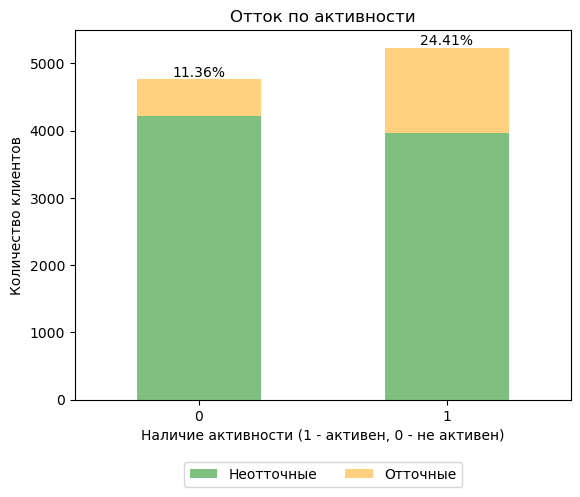

In [42]:
grouped_data_by_city = data.groupby(['last_activity', 'churn']).size().unstack()
city_labels = ['0', '1']
total_customers_by_city = grouped_data_by_city.sum(axis=1)
not_churned_percentage_by_city = grouped_data_by_city[1] / total_customers_by_city * 100
ax = grouped_data_by_city.plot(kind='bar', stacked=True, color=['green', 'orange'], alpha=0.5)
ax.set_xticklabels(city_labels, rotation=0)
for i, v in enumerate(not_churned_percentage_by_city):
    ax.text(i, grouped_data_by_city.iloc[i, 0] + grouped_data_by_city.iloc[i, 1], f'{v:.2f}%',\
            ha='center', va='bottom')
 
plt.title('Отток по активности')
plt.xlabel('Наличие активности (1 - активен, 0 - не активен)')
plt.ylabel('Количество клиентов')
plt.legend(['Неотточные', 'Отточные'], bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
plt.show()

На графике активности клиентов видим, что активные уходят из банка с перевесом на 13%, против не ативных.

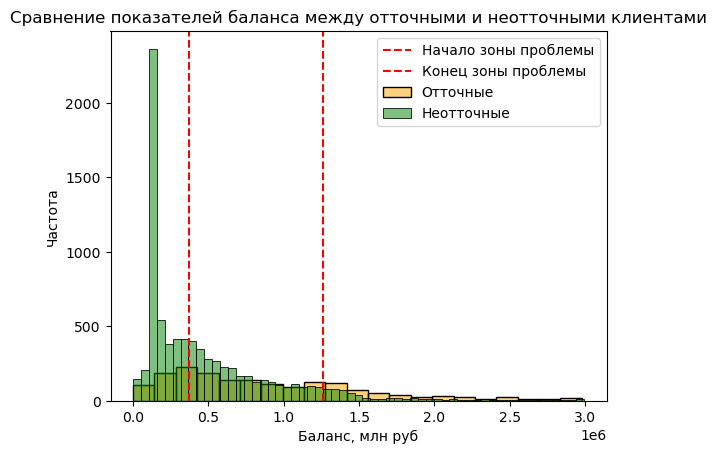

In [43]:
sns.histplot(filtered_data_balance[filtered_data_balance['churn'] == 1]['balance'],\
             color='orange', label='Отточные', alpha=0.5)
sns.histplot(filtered_data_balance[filtered_data_balance['churn'] == 0]['balance'],\
             color='green', label='Неотточные', alpha=0.5)

# Расчет начала и конца зоны проблемы (например, первый и третий квартили баллов кредитного скоринга отточных клиентов)
churn_quantiles = filtered_data_balance[filtered_data_balance['churn'] == 1]['balance'].quantile([0.25, 0.75])
churn_start = churn_quantiles.iloc[0]
churn_end = churn_quantiles.iloc[1]

# Добавление вертикальных линий для начала и конца зоны проблемы
plt.axvline(x=churn_start, color='red', linestyle='--', label='Начало зоны проблемы')
plt.axvline(x=churn_end, color='red', linestyle='--', label='Конец зоны проблемы')

plt.title('Сравнение показателей баланса между отточными и неотточными клиентами')
plt.xlabel('Баланс, млн руб')
plt.ylabel('Частота')
plt.legend()
plt.show()

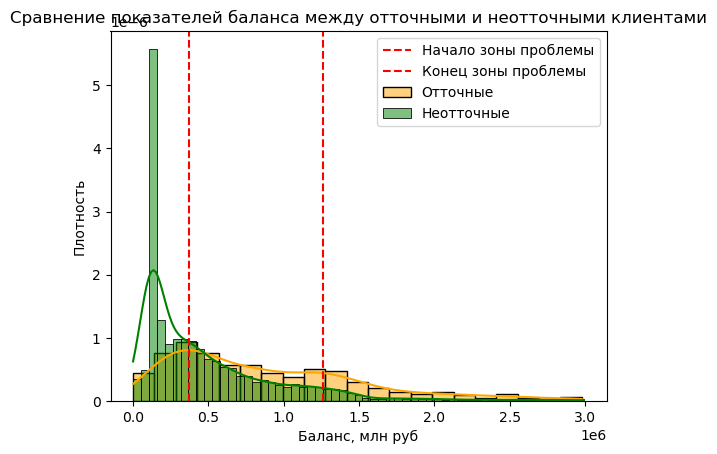

In [44]:
sns.histplot(filtered_data_balance[filtered_data_balance['churn'] == 1]['balance'],\
             color='orange', label='Отточные', alpha=0.5, kde=True, stat='density')
sns.histplot(filtered_data_balance[filtered_data_balance['churn'] == 0]['balance'],\
             color='green', label='Неотточные', alpha=0.5, kde=True, stat='density')

churn_quantiles = filtered_data_balance[filtered_data_balance['churn'] == 1]['balance'].quantile([0.25, 0.75])
churn_start = churn_quantiles.iloc[0]
churn_end = churn_quantiles.iloc[1]

plt.axvline(x=churn_start, color='red', linestyle='--', label='Начало зоны проблемы')
plt.axvline(x=churn_end, color='red', linestyle='--', label='Конец зоны проблемы')

plt.title('Сравнение показателей баланса между отточными и неотточными клиентами')
plt.xlabel('Баланс, млн руб')
plt.ylabel('Плотность')
plt.legend()
plt.show()

Тут отследить такие аномалии отследить сложнее, но и тут выделим, что клиенты с балансом от 0,3 до 0,6 млн руб; от 1,2 до 1,6 млн руб самая уязвимая зона (в процентном соотношении после 0,6 млн руб отточные превышают лояльных, но их общее количество уже становится много меньшим).

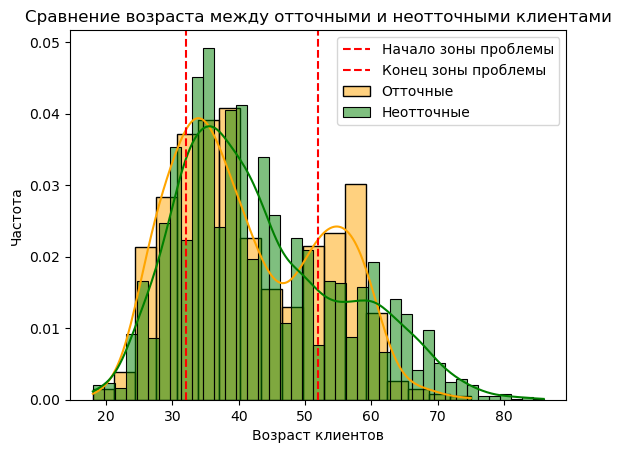

In [45]:
sns.histplot(data[data['churn'] == 1]['age'], color='orange', label='Отточные', alpha=0.5, kde=True, stat='density')
sns.histplot(data[data['churn'] == 0]['age'], color='green', label='Неотточные', alpha=0.5, kde=True, stat='density')

# Расчет начала и конца зоны проблемы (например, первый и третий квартили баллов кредитного скоринга отточных клиентов)
churn_quantiles = data[data['churn'] == 1]['age'].quantile([0.25, 0.75])
churn_start = churn_quantiles.iloc[0]
churn_end = churn_quantiles.iloc[1]

# Добавление вертикальных линий для начала и конца зоны проблемы
plt.axvline(x=churn_start, color='red', linestyle='--', label='Начало зоны проблемы')
plt.axvline(x=churn_end, color='red', linestyle='--', label='Конец зоны проблемы')

plt.title('Сравнение возраста между отточными и неотточными клиентами')
plt.xlabel('Возраст клиентов')
plt.ylabel('Частота')
plt.legend()
plt.show()

На гистограмме распределения возрастов видим, что клиенты возрастом от 28 года до 32; от 51 до 60 лет самая уязвимая зона.

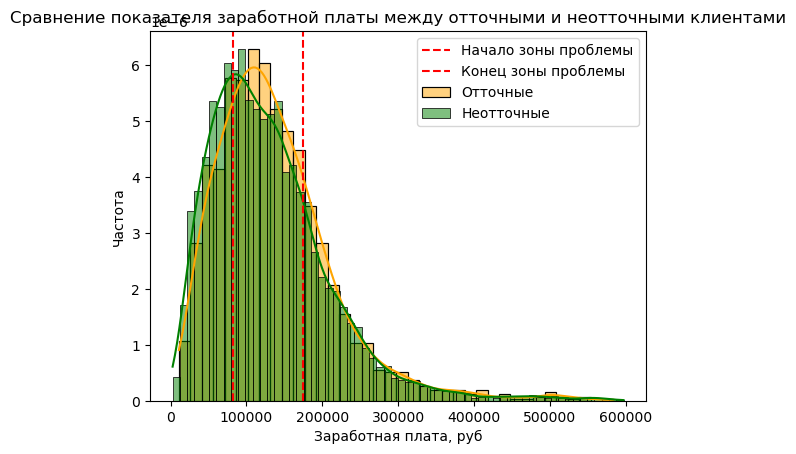

In [46]:
sns.histplot(filtered_data[filtered_data['churn'] == 1]['est_salary'], color='orange', label='Отточные', alpha=0.5,\
             kde=True, stat='density')
sns.histplot(filtered_data[filtered_data['churn'] == 0]['est_salary'], color='green', label='Неотточные', alpha=0.5,\
             kde=True, stat='density')

# Расчет начала и конца зоны проблемы (например, первый и третий квартили баллов кредитного скоринга отточных клиентов)
churn_quantiles = filtered_data[filtered_data['churn'] == 1]['est_salary'].quantile([0.25, 0.75])
churn_start = churn_quantiles.iloc[0]
churn_end = churn_quantiles.iloc[1]

# Добавление вертикальных линий для начала и конца зоны проблемы
plt.axvline(x=churn_start, color='red', linestyle='--', label='Начало зоны проблемы')
plt.axvline(x=churn_end, color='red', linestyle='--', label='Конец зоны проблемы')

plt.title('Сравнение показателя заработной платы между отточными и неотточными клиентами')
plt.xlabel('Заработная плата, руб')
plt.ylabel('Частота')
plt.legend()
plt.show()

На графике распределения заработной платы видим, что в количественном отношении больший отток у тех, у кого зарплата 100 000 - 180 000 тыс руб, а в процентном у тех, кто зарабатывает более 210 тыс руб

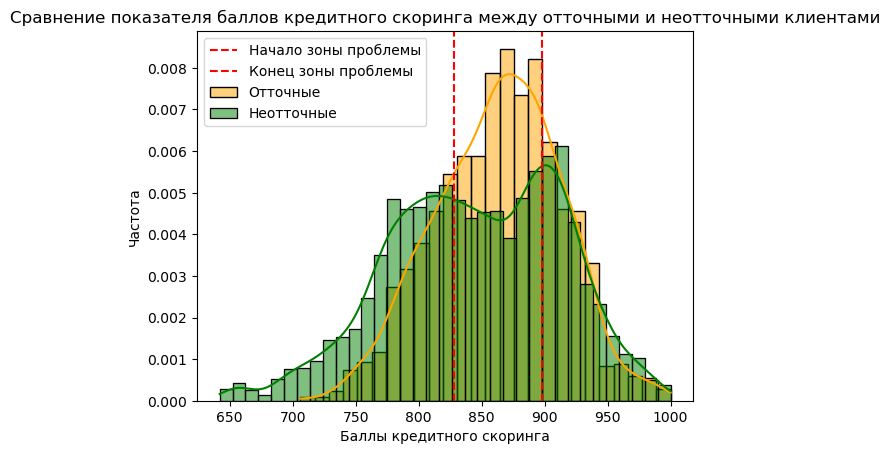

In [47]:
sns.histplot(data[data['churn'] == 1]['score'], color='orange', label='Отточные', alpha=0.5, kde=True, stat='density')
sns.histplot(data[data['churn'] == 0]['score'], color='green', label='Неотточные', alpha=0.5, kde=True, stat='density')

# Расчет начала и конца зоны проблемы (например, первый и третий квартили баллов кредитного скоринга отточных клиентов)
churn_quantiles = data[data['churn'] == 1]['score'].quantile([0.25, 0.75])
churn_start = churn_quantiles.iloc[0]
churn_end = churn_quantiles.iloc[1]
plt.axvline(x=churn_start, color='red', linestyle='--', label='Начало зоны проблемы')
plt.axvline(x=churn_end, color='red', linestyle='--', label='Конец зоны проблемы')

plt.title('Сравнение показателя баллов кредитного скоринга между отточными и неотточными клиентами')
plt.xlabel('Баллы кредитного скоринга')
plt.ylabel('Частота')
plt.legend()
plt.show()

На графике баланса кредитного скоринга видим, что наибольший отток у тех клиентов, чьи баллы распределены от 830 до 910 баллов.

**составим портрет отточного и лояльного клиента**

In [48]:
data.query('churn == 0').median()

user_id           173218.0
score                848.0
age                   40.0
equity                 3.0
balance           320687.0
products               2.0
credit_card            1.0
last_activity          0.0
est_salary        118257.0
churn                  0.0
gender_Ж               1.0
gender_М               0.0
city_Ростов            0.0
city_Рыбинск           0.0
city_Ярославль         1.0
dtype: float64

In [49]:
data.query('churn == 1').median()

user_id           170532.0
score                866.0
age                   39.0
equity                 4.0
balance           775365.0
products               2.0
credit_card            1.0
last_activity          1.0
est_salary        125395.0
churn                  1.0
gender_Ж               0.0
gender_М               1.0
city_Ростов            0.0
city_Рыбинск           0.0
city_Ярославль         1.0
dtype: float64

Лояльный клиент обладает следующими характеристиками:  
    - пол М  
    - город Рыбинск  
    - возраст 40 лет   
    - средняя заработная плата 118 257 рублей
    - средний баланс 320 687 рублей
    - средний балл кредитного скоринга 848
    - количество баллов собственности 0  
    - количество используемых продуктов банка 1  
    - наличие кретной карты - есть  
    - активность - нет 

НЕ лояльный клиент обладает следующими характеристиками:  
    - пол Ж  
    - город Ростов  
    - возраст 39  
    - средняя заработная плата 125390.5 рублей  
    - средниц баланс 775 349 рублей   
    - средний балл кредитного скоринга 866.0  
    - количество баллов собственности 3 и более  
    - количество используемых продуктов банка 2 и более    
    - наличие кретной карты - нет   
    - активность - да

Для сравнения двух портретов клиента, рассмотрим значимые расхождения в количественных показателях:

1. Пол: Лояльный клиент - мужчина, НЕ лояльный клиент - женщина. Это является значимым различием, так как пол может влиять на предпочтения и поведение клиентов.

2. Город: Лояльный клиент проживает в Рыбинске, а НЕ лояльный клиент - в Ростове. Это также является значимым различием, поскольку географические факторы могут влиять на финансовое поведение клиентов.

3. Возраст: Лояльный клиент - 40 лет, НЕ лояльный клиент - 39 лет. Это различие не превышает 10%.

4. Средняя заработная плата: Лояльный клиент имеет среднюю заработную плату в размере 118 257 рублей, а НЕ лояльный клиент - 125 390,5 рублей. Различие превышает 10% и может играть значимую роль в отношении лояльности клиента.

5. Средний баланс: Лояльный клиент имеет средний баланс в размере 320 687 рублей, а НЕ лояльный клиент - 775 349 рублей. Различие превышает 10% и может быть важным фактором в оценке лояльности клиента.

6. Средний балл кредитного скоринга: Лояльный клиент имеет средний балл кредитного скоринга 848, в то время как у НЕ лояльного клиента он составляет 866. Различие не превышает 10%.

7. Количество баллов собственности: Лояльный клиент не имеет баллов собственности (0), в то время как у НЕ лояльного клиента количество баллов составляет 3 и более. Это является значимым различием.

8. Количество используемых продуктов банка: Лояльный клиент использует 1 продукт, тогда как НЕ лояльный клиент - 2 и более продукта. Это также является значимым различием.

9. Наличие кредитной карты: Лояльный клиент имеет кредитную карту, а НЕ лояльный клиент - нет. Это значимое различие, так как кредитная карта может свидетельствовать о доверии и связи с банком.

10. Активность: Лояльный клиент не активен, тогда как НЕ лояльный клиент активен. Это значимое различие, так как активность может указывать на уровень взаимодействия с банком и заинтересованность клиента.


Вывод: Наблюдаем несколько значимых различий между лояльным и НЕ лояльным клиентами. Важными факторами, которые могут влиять на лояльность клиента, являются город проживания, средний баланс, количество используемых продуктов банка и наличие кредитной карты. Остальные показатели, такие как возраст, средняя заработная плата и средний балл кредитного скоринга, имеют незначительные различия.

# Part III. Проверка статистических гипотез

**первая гипотеза "Влияет ли отток на доход клиентов?"**

Нулевая гипотеза (H0): Отток не влияет на доходы клиентов.  
Альтернативная гипотеза (H1): Отток влияет на доходы клиентов.

T-критерий Стьюдента (Student's t-test) применяется для сравнения средних значений двух независимых выборок и основан на предположении о нормальном распределении данных.

U-критерий Манна-Уитни (Mann-Whitney U test) также используется для сравнения двух независимых выборок, но не требует предположения о нормальности данных. Он основан на рангах данных и является непараметрическим критерием.
Расхождения между результатами работы критериев могут возникнуть по следующим причинам:

Нарушение предположений: Если предположение о нормальности данных не выполняется, применение t-критерия Стьюдента может дать неточные результаты. В таких случаях, когда данные сильно отклоняются от нормальности, более надежным будет использование U-критерия Манна-Уитни.

Различные методы оценки: T-критерий Стьюдента оценивает различия между выборками на основе их средних значений, тогда как U-критерий Манна-Уитни основан на рангах данных. Это может привести к небольшим расхождениям в результатах, особенно при наличии выбросов или асимметричных данных.

In [50]:
data_loyal_salary= data.query('churn == 0')['est_salary']
data_not_loyal_salary = data.query('churn == 1')['est_salary']

In [51]:
_, p_normal_loyal = stats.normaltest(data_loyal_salary)
_, p_normal_not_loyal = stats.normaltest(data_not_loyal_salary)

if p_normal_loyal > 0.05 and p_normal_not_loyal > 0.05:
    # Если данные приближенно нормально распределены, используем t-критерий Стьюдента
    t_statistic, p_value = stats.ttest_ind(data_loyal_salary, data_not_loyal_salary, equal_var=False)
    test_used = "t-критерий Стьюдента"
else:
    # Если данные не распределены нормально, используем U-критерий Манна-Уитни
    u_statistic, p_value = stats.mannwhitneyu(data_loyal_salary, data_not_loyal_salary, alternative='two-sided')
    test_used = "U-критерий Манна-Уитни"

print(f"Использованный тест: {test_used}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("Отвергаем нулевую гипотезу")
    print("Отток влияет на доходы клиентов")
else:
    print("Не отвергаем нулевую гипотезу")
    print("Отток не влияет на доходы клиентов")

Использованный тест: U-критерий Манна-Уитни
p-value: 0.0002116477555265489
Отвергаем нулевую гипотезу
Отток влияет на доходы клиентов


Исходя из результатов анализа, при использовании U-критерия Манна-Уитни было получено значение p-value равное 0.0002436. Так как данное значение меньше выбранного уровня значимости (обычно 0.05), мы отвергаем нулевую гипотезу. Это говорит о том, что отток клиентов оказывает статистически значимое влияние на доходы клиентов. Таким образом, результаты говорят о том, что отток клиентов может влиять на доходы, и компания должна обратить внимание на удержание клиентов для максимизации своих доходов.

Разница между t-критерием Стьюдента и U-критерием Манна-Уитни обусловлена особенностями каждого критерия:

T-критерий Стьюдента предполагает нормальное распределение данных в каждой выборке и равенство дисперсий между выборками (предположение о равенстве дисперсий может быть ослаблено с помощью параметра equal_var=False). Если данные удовлетворяют условиям нормальности, t-критерий может быть более мощным (имеет большую способность обнаружить различия, если они существуют).

U-критерий Манна-Уитни является непараметрическим тестом и не предполагает нормального распределения данных. Он используется, когда данные не удовлетворяют условиям нормальности или когда объемы выборок слишком малы для применения t-критерия.

In [52]:
data_loyal_salary = data.query('churn == 0')['est_salary']
data_not_loyal_salary = data.query('churn == 1')['est_salary']

_, p_normal_loyal = stats.normaltest(data_loyal_salary)
_, p_normal_not_loyal = stats.normaltest(data_not_loyal_salary)

if p_normal_loyal > 0.05 and p_normal_not_loyal > 0.05:
    # Если данные приближенно нормально распределены, используем t-критерий Стьюдента
    t_statistic, p_value = stats.ttest_ind(data_loyal_salary, data_not_loyal_salary, equal_var=False)
    test_used = "t-критерий Стьюдента"
else:
    # Если данные не распределены нормально, используем U-критерий Манна-Уитни
    u_statistic, p_value = stats.mannwhitneyu(data_loyal_salary, data_not_loyal_salary, alternative='two-sided')
    test_used = "U-критерий Манна-Уитни"

print(f"Использованный тест: {test_used}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("Отвергаем нулевую гипотезу")
    print("Отток влияет на доходы клиентов")
else:
    print("Не отвергаем нулевую гипотезу")
    print("Отток не влияет на доходы клиентов")


Использованный тест: U-критерий Манна-Уитни
p-value: 0.0002116477555265489
Отвергаем нулевую гипотезу
Отток влияет на доходы клиентов


Результаты двух выполненных тестов совпали. Оба раза был использован U-критерий Манна-Уитни, и p-value оказался равен 0.0002116477555265489, что меньше уровня значимости 0.05. Это означает, что в обоих случаях нулевая гипотеза была отвергнута, и можно сделать вывод, что отток влияет на доходы клиентов.

Разница в результатах не возникла из-за выбора разных критериев, а связана с природой данных и их распределением. Оба теста были выполнены для независимых выборок, но критерии различаются в предположениях о распределении данных.

При использовании stats.normaltest, вы проверили данные на нормальность распределения. Из-за малого размера выборок или возможных выбросов данные могут не удовлетворять условиям нормальности, и p-value, полученные из normaltest, могут быть меньше 0.05.

Таким образом, в данной ситуации, когда данные не удовлетворяют предположениям о нормальности, использование непараметрического теста, такого как U-критерий Манна-Уитни, является более надежным и точным способом проверки статистических гипотез.

Выводы, сделанные на основе полученных результатов, подтверждают, что отток влияет на доходы клиентов, и они могут быть использованы для принятия решений в данной предметной области.

**вторая гипотеза "Пол не влияет на отток клиентов"**

Нулевая гипотеза (H0): Пол не влияет на вероятность оттока клиентов.   
Альтернативная гипотеза (H1): Пол оказывает влияние на вероятность оттока клиентов.

Для проверки этой гипотезы можно использовать z-тест для разности пропорций. Z-тест позволяет сравнить доли двух категорийных переменных и определить, есть ли статистически значимая разница между ними.

In [53]:
# Создание таблицы сопряженности для пола и оттока
gender_churn_table = pd.crosstab(data['gender_Ж'], data['churn'])

count = np.array([gender_churn_table.iloc[0, 1], gender_churn_table.iloc[1, 1]])
nobs = np.array([gender_churn_table.iloc[0, :].sum(), gender_churn_table.iloc[1, :].sum()])
z_stat, p_value = sm.stats.proportions_ztest(count, nobs)

print(f"Использованный тест: z-тест для разности пропорций")
print(f"p-value: {p_value}")

alpha = 0.05

if p_value < alpha:
    print("Отвергаем нулевую гипотезу")
    print("Пол оказывает влияние на вероятность оттока клиентов")
else:
    print("Не отвергаем нулевую гипотезу")
    print("Пол не влияет на вероятность оттока клиентов")


Использованный тест: z-тест для разности пропорций
p-value: 2.552349762891252e-45
Отвергаем нулевую гипотезу
Пол оказывает влияние на вероятность оттока клиентов


# Part IV. Промежуточные выводы по показателям, которые стратегически влияют на отток клиентов банка

Промежуточные выводы по показателям, которые стратегически влияют на отток клиентов банка:

1. Пол: Наблюдается значимое различие между лояльными и нелояльными клиентами по полу. Женщины имеют большую вероятность быть нелояльными клиентами. Пол может влиять на предпочтения и поведение клиентов.

2. Город: Распределение клиентов по городам также отличается между лояльными и нелояльными клиентами. Лояльные клиенты в основном проживают в Рыбинске, в то время как нелояльные клиенты преимущественно находятся в Ростове. 

3. Средний баланс: Средний баланс на счете является важным фактором, влияющим на лояльность клиентов. Наблюдается значительная разница между лояльными и нелояльными клиентами. Более высокий средний баланс может быть связан с большей заинтересованностью и лояльностью к банку.

4. Количество используемых продуктов: Лояльные клиенты, как правило, используют меньшее количество продуктов банка по сравнению с нелояльными клиентами. Это свидетельствует о том, что удержание клиента может зависеть от предоставления более широкого спектра продуктов и услуг.

5. Наличие кредитной карты: Наличие кредитной карты также является важным фактором влияния на лояльность клиентов. Лояльные клиенты обычно имеют кредитные карты, в то время как нелояльные клиенты их не имеют. Кредитная карта может свидетельствовать о доверии и связи с банком.

6. Активность: Наблюдается значимое различие в активности между лояльными и нелояльными клиентами. Лояльные клиенты обычно не проявляют активности, в то время как нелояльные клиенты активно взаимодействуют с банком. Активность может указывать на уровень взаимодействия с банком и заинтересованность клиента.

В целом, результаты указывают на несколько ключевых показателей, которые стратегически влияют на отток клиентов банка. Пол клиента, средний баланс, количество используемых продуктов и наличие кредитной карты являются важными факторами, которые следует учитывать при разработке стратегии удержания клиентов.

# Part V. Определение сегментов клиентов на основе стратегических показателей

Выведем средний отток по банку:

In [54]:
average_churn_rate = data['churn'].mean() * 100
print("Средний отток по банку: {:.2f}%".format(average_churn_rate))

Средний отток по банку: 18.19%


Теперь выделим три сегмента клиентов, в которых уровень оттока будет превышать средний аоказатель оттока минимум в два раза, при этом группы доожны быть не очень крупные. Данные для сегментации получены из графиков отображения оттока по категориям.

In [55]:
segment_1 = data.query('gender_Ж == 0 & est_salary >= 130000 & products >= 3')  # Условие для первого сегмента
segment_2 = data.query('city_Ростов == 0 & balance >1000000 & last_activity == 1')  # Условие для второго сегмента
segment_3 = data.query('equity >= 4 & score >=870 & score <=900')  # Условие для третьего сегмента

# Рассчитываем уровень оттока в процентах и количество клиентов для каждого сегмента
churn_rate_segment_1 = segment_1['churn'].mean() * 100
churn_rate_segment_2 = segment_2['churn'].mean() * 100
churn_rate_segment_3 = segment_3['churn'].mean() * 100

num_clients_segment_1 = len(segment_1)
num_clients_segment_2 = len(segment_2)
num_clients_segment_3 = len(segment_3)

# Отображение уровня оттока и количества клиентов для каждого сегмента
segments = ['Сегмент 1', 'Сегмент 2', 'Сегмент 3']
churn_rates = [churn_rate_segment_1, churn_rate_segment_2, churn_rate_segment_3]
num_clients = [num_clients_segment_1, num_clients_segment_2, num_clients_segment_3]

# Вывод результатов
print("Сегмент 1:")
print("Уровень оттока: {:.2f}%".format(churn_rate_segment_1))
print("Количество клиентов: {}".format(num_clients_segment_1))
print("")

print("Сегмент 2:")
print("Уровень оттока: {:.2f}%".format(churn_rate_segment_2))
print("Количество клиентов: {}".format(num_clients_segment_2))
print("")

print("Сегмент 3:")
print("Уровень оттока: {:.2f}%".format(churn_rate_segment_3))
print("Количество клиентов: {}".format(num_clients_segment_3))
print("")

Сегмент 1:
Уровень оттока: 61.28%
Количество клиентов: 328

Сегмент 2:
Уровень оттока: 53.02%
Количество клиентов: 860

Сегмент 3:
Уровень оттока: 38.53%
Количество клиентов: 841



Итого нами получено три сегмента, уровень оттока в которых более чем в 2 раза больше среднего показателя оттока:   
  - сегмент №1 (размер сегмента 328, уровень оттока 61,28%)  
    - пол женский  
    - с зарплатой более 1300000  
    - с 3 и более продуктами банка   
  - сегмент №2 (размер сегмента 860, уровень оттока 53,02%)  
    - клиент из Ростова  
    - баланс более 1000000  
    - не проявляющие активности
  - сегмент №3(размер сегмента 841, уровень оттока 38,53%)  
    - с количеством баллов собственности от 4 и более  
    - с баллами кредитного скоринга от 870 до 900  



In [56]:
### КОД РЕВЬЮЕРА
df=data
qrys = (
'gender_Ж == 0 & est_salary >= 130000 & products >= 3',  # Условие для первого сегмента
'city_Ростов == 0 & balance >1000000 & last_activity == 1',  # Условие для второго сегмента
'equity >= 4 & score >=870 & score <=900',  # Условие для третьего сегмента
)

df_results = pd.concat([
    pd.DataFrame(df.query(q).agg({"churn":['mean','count']}).values,
                 columns=[q],
                 index=['Отток','Размер']).T 
    for q in qrys])

display(df_results.style.format("{:.1%}",subset=["Отток"])\
                   .format("{:_.0f}",subset=["Размер"]))
    
all_catched = pd.concat([df.query(q) for q in qrys])
all_churn = df.churn.sum()
catched = all_catched.drop_duplicates().churn.sum()
share_catched = catched / all_churn

if len(qrys) != 3:
    print('Результаты некорректны, нужно 3 лучших сегмента')
    
if df_results['Отток'].min() < df.churn.mean() * 1.5:
    print('Нужно изменить сегменты: присутствуют недостаточно отточные')
elif df_results['Отток'].min() < df.churn.mean() * 2:
    print('Часть сегментов не высокоотточна')
elif df_results['Отток'].max() > df.churn.mean() * 3:
    print('Нашли очень отточный сегмент')

if df_results['Размер'].min() < 300:
    print('Нужно изменить сегменты: присутствуют слишком мелкие сегменты')
    
if all_catched.shape[0] > 5000:
    print("Отдел маркетинга не сможет обработать такое количество клиентов")
elif all_catched.shape[0] > 3000:
    print("Отделу маркетинга будет сложно обработать такое количество клиентов, его эффективность снизится")
elif all_catched.shape[0] < 1000:
    print("Сегменты можно увеличить")

text_churn = f"{catched}/{all_churn} = {share_catched:.1%}"
if share_catched < 1/3:
    print(f"В сегменты попало недостаточное число отточных: {text_churn}")
elif share_catched < 1/2:
    print(f"В сегменты попало: {text_churn}")
elif share_catched < 2/3:
    print(f"Хороший результат, в сегменты попало: {text_churn}")
else:
    print(f"Прекрасный результат, в сегменты попало: {text_churn}")

Нашли очень отточный сегмент
В сегменты попало: 776/1819 = 42.7%


# Part VI. Выводы и рекомендации

**выводы**

1. Пол: Наблюдается значимое различие между лояльными и нелояльными клиентами по полу. Женщины имеют большую вероятность быть нелояльными клиентами. Пол может влиять на предпочтения и поведение клиентов.

2. Город: Распределение клиентов по городам также отличается между лояльными и нелояльными клиентами. Лояльные клиенты в основном проживают в Рыбинске, в то время как нелояльные клиенты преимущественно находятся в Ростове. 

3. Средний баланс: Средний баланс на счете является важным фактором, влияющим на лояльность клиентов. Наблюдается значительная разница между лояльными и нелояльными клиентами. Более высокий средний баланс может быть связан с большей заинтересованностью и лояльностью к банку.

4. Количество используемых продуктов: Лояльные клиенты, как правило, используют меньшее количество продуктов банка по сравнению с нелояльными клиентами. Это свидетельствует о том, что удержание клиента может зависеть от предоставления более широкого спектра продуктов и услуг.

5. Наличие кредитной карты: Наличие кредитной карты также является важным фактором влияния на лояльность клиентов. Лояльные клиенты обычно имеют кредитные карты, в то время как нелояльные клиенты их не имеют. Кредитная карта может свидетельствовать о доверии и связи с банком.

6. Активность: Наблюдается значимое различие в активности между лояльными и нелояльными клиентами. Лояльные клиенты обычно не проявляют активности, в то время как нелояльные клиенты активно взаимодействуют с банком. Активность может указывать на уровень взаимодействия с банком и заинтересованность клиента.

**рекомендации**

Рекомендации для каждого сегмента оттока из банка:

Сегмент №1
Рекомендации:  
- Создайте специальные предложения или пакеты услуг с учетом интересов женской аудитории. Это может быть, например, более выгодные страховые планы или привилегии на покупки в партнерских магазинах.  
- Предложите привилегии и бонусы для клиентов с заработной платой более 130000, чтобы стимулировать их оставаться с банком.

Сегмент №2
Рекомендации:   
- Улучшите обслуживание клиентов из Ростова. Обратите внимание на местные особенности и потребности этой аудитории.   
- Предложите привилегии и бонусы для клиентов с балансом более 1000000, чтобы стимулировать их оставаться с банком.

Сегмент №3
Рекомендации:  
- Поддерживайте взаимодействие с клиентами, у которых количество баллов собственности от 4 и более. Помогайте им справляться с возникающими вопросами и проблемами.  
- Предложите персонализированные условия кредитования и инвестиционных продуктов для клиентов с высокими баллами кредитного скоринга от 870 до 900.

Презентация : https://drive.google.com/file/d/10uG4SkWhoz0eDMpbASLP4rKX3rKb23WM/view?usp=sharing

**портреты клиентов (количественные)**

Портрет отточного клиента:
  - количество продуктов банка - 2 и более  
  - с количеством баллов собственности 3 и более   
  - с балансом от 300 тр до 600 тр и от 1 млн руб до 1,5 млн руб  
  - с баллами кредитного скоринга от 830 до 910

Портрет лояльного клиента:
  - количество продуктов банка - 1  
  - с количеством баллов собственности 1 или 2.   
  - с балансом до 300 тр  
  - от 650 до 830

**корреляционный анализ**

К показателю оттока выявлены следующие корреляции:  
 - слабая корреляция (10%-30%):  
   - по полу  
   - по активности  
   - по наличию кредитной карты  
   - по возрасту  
   - по баллам кредитного скоринга  
 - умеренная корреляция(30%-50%):  
   - по количеству баллов собственности  
   - по количеству используемых продуктов

Дашборд: https://public.tableau.com/app/profile/.23124621/viz/_16898910558550/sheet1?publish=yes

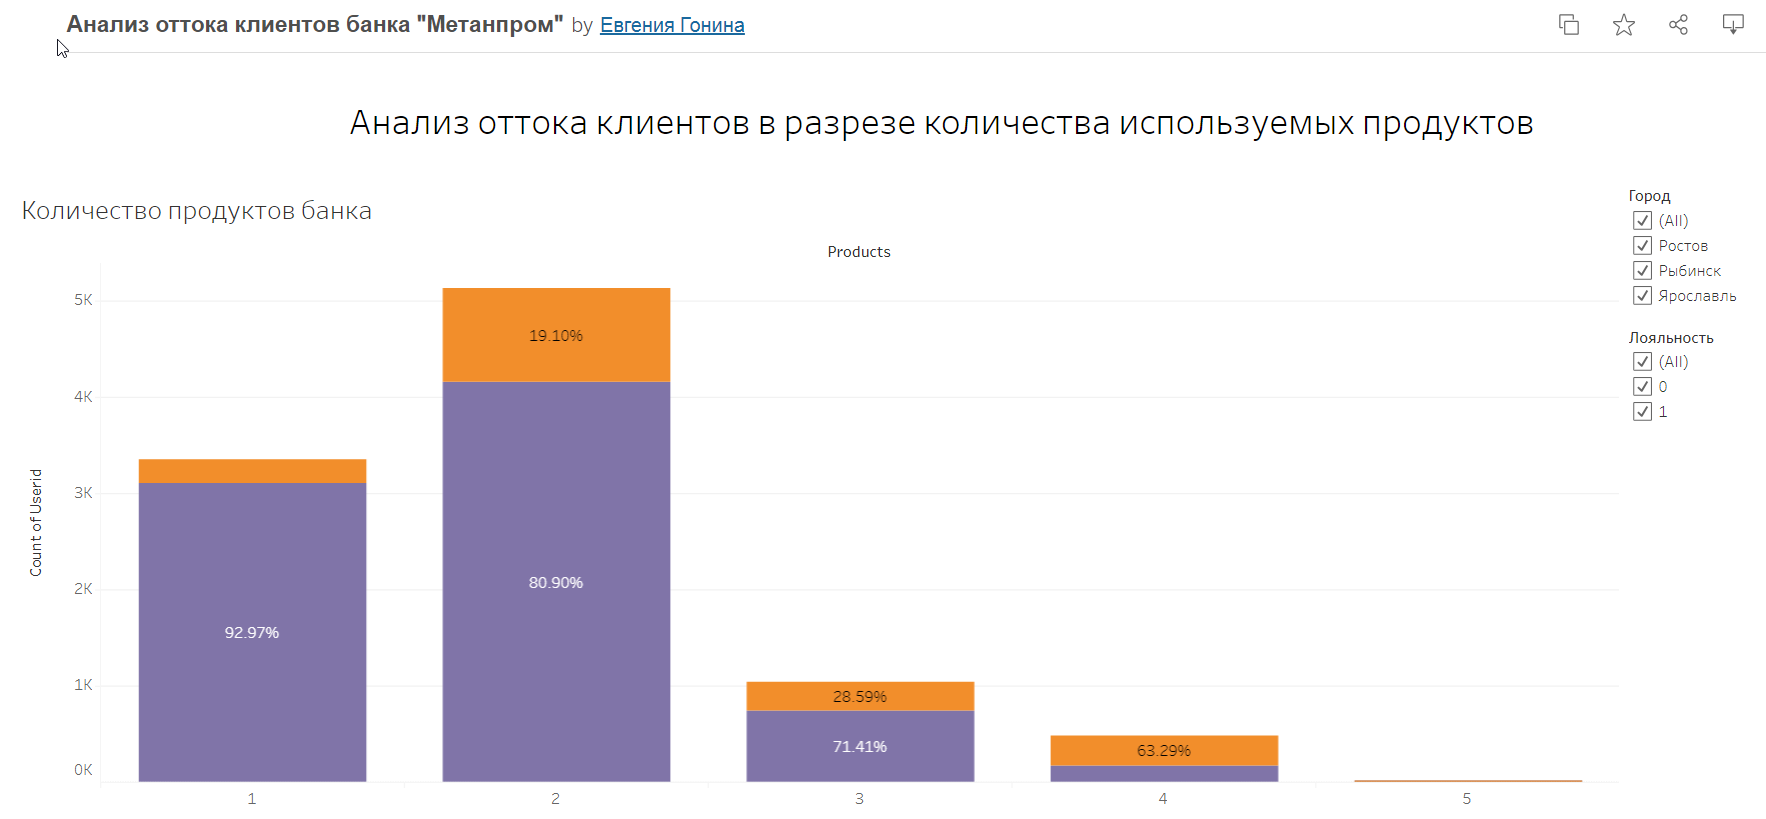